In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import bloscpack as bp


from utils import*

In [2]:
points_c=get_file_ply("./data/cow_2.obj")
#points_c=get_file("./data/horse.npts")

In [3]:
# First, generate the sphere points and normals
#points_c = sphere_points_and_normals_torch(0.3, 10,10)

# Now, plot the result
#plot_sphere_with_normals(points_c, show_normals=True)

In [4]:
dico=dict()
bord=get_borders(points_c)
create_quadtree(dico,0,20,points_c,bord,"")

In [5]:
#save_quadtree_viz(points_c,dico)

In [6]:
def get_min_width(dico,D):
    min_width=1e9
    for node in dico:
        if (dico[node][2]<min_width and dico[node][0]<=D ):
            min_width=dico[node][2]
    return min_width
        



def get_os(nb_s,dico,D):
    cpt_p=0
    s_p=torch.ones((nb_s,6))
    o_s=torch.ones((nb_s,8,5)) #interpolation weight , width , center
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,l_points=dico[node]

            for p in l_points:
                s_p[cpt_p]=p.clone()

                gx,dx,gy,dy,gz,dz=dico[node[:-1]][-2]

                tmp_o_vec=torch.empty((8,5))
                for idx_nbgr in range(1,9):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[cpt_p,0]-gx)/(dx-gx)
                    v=(s_p[cpt_p,1]-gy)/(dy-gy)
                    w=(s_p[cpt_p,2]-gz)/(dz-gz)
                    

                    
                    if idx_nbgr==1:
                        tmp_o_vec[0,0]=(1-u)*v*w
                    if idx_nbgr==2:
                        tmp_o_vec[1,0]=u*v*w
                    if idx_nbgr==3:
                        tmp_o_vec[2,0]=(1-u)*(1-v)*w
                    if idx_nbgr==4:
                        tmp_o_vec[3,0]=u*(1-v)*w
                    if idx_nbgr==5:
                        tmp_o_vec[4,0]=(1-u)*v*(1-w)
                    if idx_nbgr==6:
                        tmp_o_vec[5,0]=u*v*(1-w)
                    if idx_nbgr==7:
                        tmp_o_vec[6,0]=(1-u)*(1-v)*(1-w)
                    if idx_nbgr==8:
                        tmp_o_vec[7,0]=u*(1-v)*(1-w)
                        
                
                
                
                o_s[cpt_p]=tmp_o_vec.clone()
                cpt_p+=1
    return s_p,o_s
#s_p : (50,6)
#o_s : (50,8,5)

                
                
            
            
#s_p,o_s=get_os(points_c.shape[0],dico,5)

#print(o_s.shape)





D=5
#l_s,l_o=get_os(s_p.shape[0],dico,D)

def get_V_q(q,l_o,l_s):
    q_vec=torch.empty((l_o.shape[0],8,3))
    q_vec[:,:,0]=q[0]
    q_vec[:,:,1]=q[1]
    q_vec[:,:,2]=q[2]
    
    q_vec[:,:,0]-=l_o[:,:,2]
    q_vec[:,:,0]/=l_o[:,:,1]
    q_vec[:,:,1]-=l_o[:,:,3]
    q_vec[:,:,1]/=l_o[:,:,1]
    q_vec[:,:,2]-=l_o[:,:,4]
    q_vec[:,:,2]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q_vec)**2,dim=2)/(1.5**2))
    
    
    test=test*l_o[:,:,0]
    
    res=torch.empty((l_o.shape[0],8,3))
    res[:,0]=l_s[:,3:]
    res[:,1]=l_s[:,3:]
    res[:,2]=l_s[:,3:]
    res[:,3]=l_s[:,3:]
    res[:,4]=l_s[:,3:]
    res[:,5]=l_s[:,3:]
    res[:,6]=l_s[:,3:]
    res[:,7]=l_s[:,3:]

    res[:,0,0]*=test[:,0]
    res[:,0,1]*=test[:,0]
    res[:,0,2]*=test[:,0]
    res[:,1,0]*=test[:,1]
    res[:,1,1]*=test[:,1]
    res[:,1,2]*=test[:,1]
    res[:,2,0]*=test[:,2]
    res[:,2,1]*=test[:,2]
    res[:,2,2]*=test[:,2]
    res[:,3,0]*=test[:,3]
    res[:,3,1]*=test[:,3]
    res[:,3,2]*=test[:,3]
    res[:,4,0]*=test[:,4]
    res[:,4,1]*=test[:,4]
    res[:,4,2]*=test[:,4]
    res[:,5,0]*=test[:,5]
    res[:,5,1]*=test[:,5]
    res[:,5,2]*=test[:,5]
    res[:,6,0]*=test[:,6]
    res[:,6,1]*=test[:,6]
    res[:,6,2]*=test[:,6]
    res[:,7,0]*=test[:,7]
    res[:,7,1]*=test[:,7]
    res[:,7,2]*=test[:,7]
    
    res=torch.sum(res,dim=(0,1))
    
    return res
    
    #q_vec=torch.where( (q_vec>=0)&(q_vec<100), )



In [7]:
#octree depth

#grid resolution


#
#l_s,l_o=get_os(s_p.shape[0],dico,D)

def get_V(points_c,dico,D,name="V.blp"):
    s_p=points_c[:,:3]
    l_s,l_o=get_os(s_p.shape[0],dico,D)

    borders=get_borders(points_c)
        
    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()
    min_z=borders[4].item()
    max_z=borders[5].item()
    
    min_coord=min(min_x,min_y)
    min_coord=min(min_coord,min_z)
    min_coord=min_coord
    
    max_coord=max(max_x,max_y)
    max_coord=max(max_coord,max_z)
    max_coord=max_coord
    
    X, Y, Z = np.mgrid[min_x:max_x:256j, min_y:max_y:256j, min_z:max_z:256j]
    res=256
    values =np.zeros((res,res,res,3))
    
    for ax in range(0,res):
        print(ax)
        for ay in range(0,res):
            for az in range(0,res):
                tmp_x=X[ax,ay,az]
                tmp_y=Y[ax,ay,az]
                tmp_z=Z[ax,ay,az]
    
                tmp_q=torch.empty(3)
                tmp_q[0]=tmp_x
                tmp_q[1]=tmp_y
                tmp_q[2]=tmp_z
                
                score=get_V_q(tmp_q,l_o,l_s)
                
                values[ax,ay,az]=score
    bp.pack_ndarray_to_file(values, name)
    
#get_V(points_c,dico,D=15,name="V.blp")   

In [8]:
def show_V(name="V.blp"):

    borders=get_borders(points_c)
        
    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()
    min_z=borders[4].item()
    max_z=borders[5].item()
    
    min_coord=min(min_x,min_y)
    min_coord=min(min_coord,min_z)
    min_coord=min_coord
    
    max_coord=max(max_x,max_y)
    max_coord=max(max_coord,max_z)
    max_coord=max_coord

    X, Y, Z = np.mgrid[min_x:max_x:64j, min_y:max_y:64j, min_z:max_z:64j]
    
    values = bp.unpack_ndarray_from_file(name)
    rendu=np.sqrt(values[:,:,:,0]**2+values[:,:,:,1]**2+values[:,:,:,2]**2)
    layout = go.Layout(
        autosize=False,
        width=1000,
        height=1000,
        xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
        yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
        margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
        )
        
    fig = go.Figure(data=go.Volume(
    x=X[:,:,:].flatten(),
    y=Y[:,:,:].flatten(),
    z=Z[:,:,:].flatten(),
    value=rendu.flatten(),
    isomin=2,
    isomax=np.max(rendu),
    colorscale='greys',
    opacity=0.5, # needs to be small to see through all surfaces
    surface_count=21, # needs to be a large number for good volume rendering
    ),layout=layout)
    fig.show()

In [9]:
#show_V(name="V.blp")

In [10]:
values = bp.unpack_ndarray_from_file("V.blp")
values=torch.from_numpy(values)

In [11]:
def compute_divergence(V):
    # Initialize the divergence tensor with the same spatial dimensions, but only one channel
    div_V = torch.zeros((V.shape[0], V.shape[1], V.shape[2]))
    
    # Compute the x-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[1:-1, :,:] += (V[2:, :,:, 0] - V[:-2, :,:, 0]) / 2
    
    # Compute the y-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[:, 1:-1,:] += (V[:, 2:,:, 1] - V[:, :-2,:, 1]) / 2
    div_V[:, :,1:-1] += (V[:,: ,2:, 2] - V[:, :, :-2, 2]) / 2
    
    
    # Handle the borders if necessary (here we assume a zero-gradient boundary condition)
    # This can be replaced with a more appropriate condition for your specific case
    div_V[0, :,:] += (V[1, :,:, 0] - V[0, :,:, 0])
    div_V[-1, :,:] += (V[-1, :,:, 0] - V[-2, :,:, 0])
    div_V[:, 0,:] += (V[:, 1,:, 1] - V[:, 0,:, 1])
    div_V[:, -1,:] += (V[:, -1,:, 1] - V[:, -2,:, 1])
    div_V[:,:, 0] += (V[:, :,1, 1] - V[:,:, 0, 1])
    div_V[:,:, -1] += (V[:, :,-1, 1] - V[:,:, -2, 1])

    return div_V

    

In [12]:
test=compute_divergence(values)
print(test.shape)

torch.Size([256, 256, 256])


In [13]:
borders=get_borders(points_c)
        
min_x=borders[0].item()
max_x=borders[1].item()
min_y=borders[2].item()
max_y=borders[3].item()
min_z=borders[4].item()
max_z=borders[5].item()

min_coord=min(min_x,min_y)
min_coord=min(min_coord,min_z)
min_coord=min_coord

max_coord=max(max_x,max_y)
max_coord=max(max_coord,max_z)
max_coord=max_coord

X_plot, Y_plot = np.mgrid[0:256:256j, 0:256:256j]





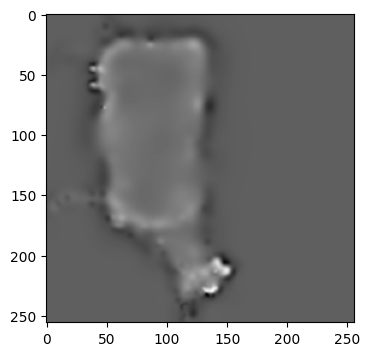

In [27]:
fig = plt.figure(figsize=plt.figaspect(0.25))
slice=30
ax = fig.add_subplot(1, 1, 1)
plt.imshow(test[:,:,slice],cmap="gray")


#plt.quiver(X_plot,Y_plot,values[:,:,slice,0],values[:,:,slice,1],alpha = 0.5,scale = 0.1)


In [15]:
borders=get_borders(points_c)
        
min_x=borders[0].item()
max_x=borders[1].item()
min_y=borders[2].item()
max_y=borders[3].item()
min_z=borders[4].item()
max_z=borders[5].item()

min_coord=min(min_x,min_y)
min_coord=min(min_coord,min_z)
min_coord=min_coord

max_coord=max(max_x,max_y)
max_coord=max(max_coord,max_z)
max_coord=max_coord

X, Y, Z = np.mgrid[min_x:max_x:64j, min_y:max_y:64j, min_z:max_z:64j]

layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
    yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
    margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
    )
    
fig = go.Figure(data=go.Volume(
x=X[:,:,:].flatten(),
y=Y[:,:,:].flatten(),
z=Z[:,:,:].flatten(),
value=test.flatten(),
isomin=2,
isomax=np.max(3),
colorscale='greys',
opacity=0.5, # needs to be small to see through all surfaces
surface_count=21, # needs to be a large number for good volume rendering
),layout=layout)
#fig.show()